# Download US power output PV Watts (version 8) 

## Documentation: https://developer.nrel.gov/docs/api-key/
## https://pvwatts.nrel.gov/downloads/pvwattsv5.pdf

In [1]:
import numpy as np
import scipy as sp
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [2]:
hrh_apikey = 'GNoTfD5IZWwIEz24zB5Wn0aEhDvNJSep5bwapzTI'
data_path = '/Users/hrh/Desktop/AI/erdos/rapower_data/'

In [3]:
# 1. Define PVWatts parameters and your API key
parameters = {
    'format': 'json',
    'system_capacity': 1000,
    'module_type': 0,
    'losses': 14.08,
    'array_type': 1,
    'tilt': 40,
    'azimuth': 180,
    'lat': 40.0099983215332,
    'lon':  -105.2600021362305,
    'dataset': 'nsrdb',
    'radius': 25,
    'timeframe': 'monthly',
    'api_key': hrh_apikey  # Replace with your API key
}



In [4]:
url = 'https://developer.nrel.gov/api/pvwatts/v8'

# 2. Send request
response = requests.get(url, params=parameters)
data = response.json()

# 3. Convert the output data to a DataFrame
df = pd.DataFrame(data['outputs'])

print(response)

<Response [200]>


In [5]:
##### Try to get data for California on a grid with lat_delta and lon_delta resolution
# lat_delta = 0.25
# lon_delta = 0.25

# # #CONUS box
# # top = 49.3457868 # north lat
# # left = -124.7844079 # west long
# # right = -66.9513812 # east long
# # bottom =  24.7433195 # south lat

# #California box
# top    = 42.009518
# bottom = 32.534156
# left   = -124.409591 
# right  =  -114.131211


## Define list of lat lon coordinates (either for CONUS or California)

<font color ='red'> PVWatts API access currently has a limit of 1000 queries per hour. So, data has to be downloaded one chunk (size<1000) at a time </font>

In [6]:
# 1. Define a list of latitudes and longitudes for CONUS
all_data = []
##### Read lats and lons CA_grid_dataframe #############
data_path2     = '/Users/hrh/Desktop/AI/erdos/SolarFarmPrediction/data/'
ca_gridpath    = data_path2 + 'CA_data_version_3.csv'

df_main             = pd.read_csv(ca_gridpath)
ca_grid             = df_main.loc[df_main['State']=='CA']
#ca_grid_usable      = ca_grid.loc[ca_grid['land_cover']==1.0]
ca_coords           = list(zip(ca_grid['lat'], ca_grid['lon']))
#Check if ca_coords are within california grid box
ca_lats = [item[0] for item in ca_coords] 
ca_lons = [item[1] for item in ca_coords]
(min(ca_lats),max(ca_lats)),(min(ca_lons),max(ca_lons))
ca_grid

,lat,lon,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,slope,land_cover,elevation
0,40.417985,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,40.437539,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,40.457093,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,40.398431,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,40.417985,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102145,34.277993,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,201.0
102146,34.297547,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,1.0,228.0
102147,34.317101,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,1.0,148.0
102148,34.258439,-114.138592,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,112.0


### Reduce the grid points to those with solar farms and a a few sites with no solar farms

In [7]:
solar_farms = ca_grid.loc[ca_grid['Solar_farm_present']==1]
solar_farms

,lat,lon,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,slope,land_cover,elevation
13910,38.032383,-122.508744,1.0,CA,0.019112,1.438727,6.0,0.019112,0.0,0.0,"2FJV+G3 San Rafael, CA, USA",0.0,2.0,1.0
16288,40.633080,-122.314591,1.0,CA,0.026765,1.910786,702.0,0.026765,0.0,0.0,"JMJJ+R4 Columbia, Redding, CA, USA",1.0,1.0,185.0
16536,40.496202,-122.293018,1.0,CA,0.014312,1.127613,3.0,0.014312,0.0,0.0,"6759 Airport Rd, Redding, CA 96002, USA",0.0,1.0,149.0
16678,38.267033,-122.271446,1.0,CA,0.034076,NaN,3.0,0.034076,0.0,1.0,"7PCC+W7 Napa, CA, USA",1.0,1.0,9.0
18748,38.227924,-122.098865,1.0,CA,0.032722,2.263317,4.0,0.032722,0.0,0.0,"6WJ4+QW Fairfield, CA, USA",0.0,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96540,35.588119,-115.432945,1.0,CA,5.889066,179.797992,6.0,5.889066,0.0,0.0,"HHP8+27 Calada, CA, USA",1.0,1.0,816.0
96753,33.828249,-115.389800,1.0,CA,14.031455,373.646009,6.0,14.031455,0.0,0.0,"RJ96+C8 Desert Center, CA, USA",0.0,1.0,216.0
99819,33.574045,-114.915204,1.0,CA,0.308603,NaN,3.0,0.308603,0.0,1.0,"H38J+CM Blythe, CA, USA",1.0,1.0,131.0
99948,33.574045,-114.893631,1.0,CA,0.033762,NaN,3.0,0.033762,0.0,1.0,"H38W+3C Blythe, CA, USA",0.0,1.0,133.0


### Let us pick locations where only one feature is restricting:

#### 1) Slope 2) Elevation 3) Land Cover

In [8]:
high_slope = ca_grid.loc[(ca_grid['Solar_farm_present']!=1) & (ca_grid['slope']>=45) &(ca_grid['land_cover']!=0)]
high_slope

,lat,lon,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,slope,land_cover,elevation
4695,41.845435,-123.522654,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.0,1.0,1503.0
5704,41.258812,-123.393219,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,1.0,750.0
6063,41.337029,-123.350074,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,1.0,818.0
7178,41.923652,-123.220638,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,1.0,1776.0
7561,38.482128,-123.155921,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,1.0,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91922,35.940093,-116.036977,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,1.0,1156.0
94108,34.805954,-115.756533,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,1.0,1535.0
95735,34.981941,-115.540808,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,1.0,1787.0
100797,33.046084,-114.742623,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,1.0,289.0


In [9]:
high_elevation = ca_grid.loc[(ca_grid['Solar_farm_present']!=1) & (ca_grid['elevation']>2500) & (ca_grid['slope']<45) & (ca_grid['land_cover']!=0)]
high_elevation 

,lat,lon,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,slope,land_cover,elevation
9545,41.024163,-122.961768,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,1.0,2569.0
17096,41.415245,-122.249873,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,1.0,2677.0
17352,41.376137,-122.228301,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,1.0,2555.0
17353,41.395691,-122.228301,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,1.0,3027.0
17354,41.415245,-122.228301,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,1.0,3646.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85632,34.141114,-116.727299,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,1.0,2517.0
85633,34.160669,-116.727299,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,1.0,2553.0
85842,34.180223,-116.705726,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,1.0,2555.0
86029,33.789140,-116.684153,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,1.0,2895.0


In [10]:
land_cover = ca_grid.loc[(ca_grid['Solar_farm_present']!=1) & (ca_grid['elevation'] < 2500) & (ca_grid['slope']<45) & (ca_grid['land_cover']==0)]
land_cover

,lat,lon,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,slope,land_cover,elevation
0,40.417985,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,40.437539,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,40.457093,-124.471847,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,40.398431,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,40.417985,-124.450274,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102025,34.551751,-114.397462,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,137.0
102074,34.434426,-114.332745,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,137.0
102138,34.356210,-114.203309,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,138.0
102144,34.336656,-114.181737,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,138.0


### Let us pick locations with low elevation, low slope and no land cover restrictions 

In [11]:
## I am calling these points rad_limited because they are not infeasible due to any other feature considered so far.
rad_limited = ca_grid.loc[(ca_grid['Solar_farm_present']!=1) & (ca_grid['elevation'] < 2500) & (ca_grid['slope']<45) & (ca_grid['land_cover']!=0)]
rad_limited

,lat,lon,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,slope,land_cover,elevation
34,40.437539,-124.407129,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,1.0,76.0
58,40.417985,-124.385556,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,1.0,270.0
59,40.437539,-124.385556,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,1.0,218.0
60,40.457093,-124.385556,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,1.0,193.0
61,40.476647,-124.385556,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,1.0,69.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102143,34.317101,-114.181737,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,1.0,370.0
102145,34.277993,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,201.0
102146,34.297547,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,1.0,228.0
102147,34.317101,-114.160164,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,1.0,148.0


In [13]:
max(solar_farms['elevation'])

1054.0

In [14]:
len(solar_farms)

207

In [12]:
## Number of locations to be sampled from rad_limited , 100 locations from high elevation points, 100 for land cover restrictions ##############
radlim_size = 1000 - (len(solar_farms) + len(high_slope) + 100 + 100)
radlim_size

425

### Sample points from the dataframes to have a list of 1000 locations 

In [13]:
sample_high_elevation = high_elevation.sample(100,random_state=42)
sample_high_elevation

,lat,lon,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,slope,land_cover,elevation
60070,37.582639,-119.294433,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,2862.0
54218,38.169262,-119.833747,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,NaN,2513.0
64321,37.387097,-118.884554,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,3216.0
65597,37.015569,-118.755119,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,1.0,3307.0
59206,38.364803,-119.380723,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,2609.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57566,38.423465,-119.531731,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2625.0
68720,37.015569,-118.453103,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,1.0,3435.0
69856,36.389838,-118.345240,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,1.0,2796.0
64090,37.113340,-118.906127,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,2640.0


In [14]:
sample_land_cover = land_cover.sample(100, random_state=42)

In [15]:
sample_rad_limited = rad_limited.sample(425,random_state=42)

### Combine data frames 

In [16]:
ca_grid_sampled = pd.concat([sample_rad_limited,sample_high_elevation,high_slope,solar_farms,sample_land_cover])
ca_grid_sampled

,lat,lon,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,slope,land_cover,elevation
974,41.121933,-124.083541,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,1.0,241.0
40830,34.571305,-120.610359,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1.0,244.0
22134,37.426206,-121.839995,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,1.0,359.0
82155,33.750032,-117.072459,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,1.0,607.0
33447,35.705444,-121.063383,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,1.0,506.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3250,39.635821,-123.695234,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,0.0,241.0
31727,41.063271,-121.192818,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,1447.0
42195,38.579898,-120.545641,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,0.0,1021.0
30699,40.183336,-121.257536,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,0.0,1424.0


In [17]:
#### Get lat and lons 
ca_coords_sample           = list(zip(ca_grid_sampled['lat'], ca_grid_sampled['lon']))
len(ca_coords_sample )

1000

In [18]:
%%time
    for (lat,lon) in ca_coords_sample:
        parameters = {
            'format': 'json',
            'system_capacity': 1000, #1000kW = 1 MW, 1 MW or greater is considered utility-scale
            'module_type': 0,       # 0- Standard module, 1- Permium, 2-Thin film
            'losses': 14,           # Losses in percentage
            'array_type': 0,        # Open Rack: Also known as ground mount.
            'tilt': 40,
            'azimuth': 180,         # This means that the solar array is facing South in the Northeren Hemisphere
            'lat': lat,
            'lon': lon,
            'dataset': 'nsrdb',      #tmy2 is 1960-1990, tmy3 is 1990-2005
            'radius': 100,            # 0-Pick the station nearest to the given (lat,lon),e.g: 50 -50 miles
            'timeframe': 'monthly',
            'api_key': hrh_apikey
        }

        url = 'https://developer.nrel.gov/api/pvwatts/v8'
        response = requests.get(url, params=parameters)
        data = response.json()
             
        # Extract and append relevant data to the all_data list
        # Extract relevant data
        #print('Processing (lat,lon):',lat,lon,'\n')
        
        # Check if 'outputs' is in the data
        if 'outputs' not in data:
            print(f"No data available for latitude {lat} and longitude {lon}")
            continue

        output_data = data['outputs']
        input_data  = data['inputs']

        output_data['latitude']  = input_data['lat']
        output_data['longitude'] = input_data['lon']
        all_data.append(output_data)
        
        
# Convert all_data to a DataFrame
df = pd.DataFrame(all_data)

print(df)

No data available for latitude 36.66359516358658 and longitude -121.68898667288934
No data available for latitude 39.65537466933158 and longitude -121.6458415588378
No data available for latitude 38.2865866601672 and longitude -121.4732611026316
No data available for latitude 38.44301957550027 and longitude -121.4732611026316
No data available for latitude 38.52123603316681 and longitude -121.4732611026316
No data available for latitude 38.57989837641671 and longitude -121.4732611026316
No data available for latitude 36.85913630775292 and longitude -121.43011598858006
No data available for latitude 38.3452490034171 and longitude -121.43011598858006
No data available for latitude 38.3452490034171 and longitude -121.40854343155428
No data available for latitude 38.36480311783374 and longitude -121.40854343155428
No data available for latitude 38.52123603316681 and longitude -121.40854343155428
No data available for latitude 38.36480311783374 and longitude -121.3869708745285
No data avail

In [28]:
df

,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,solrad_annual,capacity_factor,latitude,longitude
0,"[74220.87028531785, 81853.14136114981, 113785....","[89.71184293662846, 99.27773039711408, 142.244...","[2.893930417310596, 3.54563322846836, 4.588518...","[78072.6330660135, 86028.3788149819, 119490.90...",1.351093e+06,4.647099,15.423437,41.12193325057913,-124.08354050275032
1,"[126910.2673240865, 120953.4951399055, 141626....","[157.4086237937431, 149.0061670892798, 176.243...","[5.07769754173365, 5.321648824617137, 5.685276...","[132842.0433185665, 126964.0270624705, 148524....",1.584719e+06,5.449958,18.090397,34.57130492100674,-120.6103588216006
2,"[93296.39819471513, 94001.73832147277, 148309....","[115.084787852927, 118.3805626840665, 188.1425...","[3.712412511384743, 4.227877238716659, 6.06911...","[97913.03195989196, 98663.10917491073, 155325....",1.631746e+06,5.776466,18.627235,37.42620562583531,-121.83999457206976
3,"[135309.814274307, 123283.186730356, 151155.07...","[170.4540593143596, 156.1909634208012, 197.380...","[5.498518042398696, 5.578248693600041, 6.36712...","[141635.9382116481, 129010.6773886973, 158297....",1.729305e+06,6.246080,19.740929,33.75003211550811,-117.07245946937358
4,"[118738.5864463819, 113457.5578228151, 148653....","[145.3158467865841, 140.9581036133796, 186.941...","[4.687607960857552, 5.034217986192131, 6.03037...","[124417.4689334649, 118908.0059730483, 155818....",1.773539e+06,6.172914,20.245884,35.70544355717151,-121.06338251914188
...,...,...,...,...,...,...,...,...,...
706,"[95440.5901910352, 93998.41634249181, 144318.3...","[116.4577899599085, 118.7513221383705, 183.664...","[3.756702901932531, 4.241118647798944, 5.92466...","[100121.1940289242, 98657.6735969481, 151375.3...",1.641575e+06,5.835609,18.739443,37.68040911325155,-121.75370434396667
707,"[94976.9852906529, 114986.5536613047, 137878.3...","[115.1690824517297, 143.4615398841854, 176.186...","[3.715131691991282, 5.123626424435193, 5.68342...","[99639.20509684668, 120474.0703331733, 144447....",1.655330e+06,5.937336,18.896457,38.52123603316681,-121.7321317869409
708,"[94170.89732615808, 114785.4876412959, 138913....","[114.2316935895849, 143.2433768405962, 177.622...","[3.684893341599511, 5.115834887164149, 5.72975...","[98797.55583494747, 120259.7496076713, 145519....",1.645609e+06,5.906287,18.785492,38.57989837641671,-121.7321317869409
709,"[94238.0739849696, 94990.60328770743, 144919.4...","[114.9233895392341, 120.1330638607807, 184.427...","[3.707206114168843, 4.290466566456453, 5.94925...","[98877.5361926037, 99678.60762302084, 152021.4...",1.645558e+06,5.860832,18.784908,37.69996322766818,-121.71055922991512


In [19]:
df.to_csv(data_path2+'nsrdb_monthly.csv',index=False)

In [21]:
ca_rad = pd.read_csv(data_path2+'nsrdb_monthly.csv')
ca_rad

,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,solrad_annual,capacity_factor,latitude,longitude
0,"[74220.87028531785, 81853.14136114981, 113785....","[89.71184293662846, 99.27773039711408, 142.244...","[2.893930417310596, 3.54563322846836, 4.588518...","[78072.6330660135, 86028.3788149819, 119490.90...",1.351093e+06,4.647099,15.423437,41.121933,-124.083541
1,"[126910.2673240865, 120953.4951399055, 141626....","[157.4086237937431, 149.0061670892798, 176.243...","[5.07769754173365, 5.321648824617137, 5.685276...","[132842.0433185665, 126964.0270624705, 148524....",1.584719e+06,5.449958,18.090397,34.571305,-120.610359
2,"[93296.39819471513, 94001.73832147277, 148309....","[115.084787852927, 118.3805626840665, 188.1425...","[3.712412511384743, 4.227877238716659, 6.06911...","[97913.03195989196, 98663.10917491073, 155325....",1.631746e+06,5.776466,18.627235,37.426206,-121.839995
3,"[135309.814274307, 123283.186730356, 151155.07...","[170.4540593143596, 156.1909634208012, 197.380...","[5.498518042398696, 5.578248693600041, 6.36712...","[141635.9382116481, 129010.6773886973, 158297....",1.729305e+06,6.246080,19.740929,33.750032,-117.072459
4,"[118738.5864463819, 113457.5578228151, 148653....","[145.3158467865841, 140.9581036133796, 186.941...","[4.687607960857552, 5.034217986192131, 6.03037...","[124417.4689334649, 118908.0059730483, 155818....",1.773539e+06,6.172914,20.245884,35.705444,-121.063383
...,...,...,...,...,...,...,...,...,...
706,"[95440.5901910352, 93998.41634249181, 144318.3...","[116.4577899599085, 118.7513221383705, 183.664...","[3.756702901932531, 4.241118647798944, 5.92466...","[100121.1940289242, 98657.6735969481, 151375.3...",1.641575e+06,5.835609,18.739443,37.680409,-121.753704
707,"[94976.9852906529, 114986.5536613047, 137878.3...","[115.1690824517297, 143.4615398841854, 176.186...","[3.715131691991282, 5.123626424435193, 5.68342...","[99639.20509684668, 120474.0703331733, 144447....",1.655330e+06,5.937336,18.896457,38.521236,-121.732132
708,"[94170.89732615808, 114785.4876412959, 138913....","[114.2316935895849, 143.2433768405962, 177.622...","[3.684893341599511, 5.115834887164149, 5.72975...","[98797.55583494747, 120259.7496076713, 145519....",1.645609e+06,5.906287,18.785492,38.579898,-121.732132
709,"[94238.0739849696, 94990.60328770743, 144919.4...","[114.9233895392341, 120.1330638607807, 184.427...","[3.707206114168843, 4.290466566456453, 5.94925...","[98877.5361926037, 99678.60762302084, 152021.4...",1.645558e+06,5.860832,18.784908,37.699963,-121.710559


In [22]:
#Rename lat and lon
ca_rad  = ca_rad.rename(columns={'latitude':'lat','longitude':'lon'})

# Convert DataFrame to GeoDataFrame
geometry       = [Point(xy) for xy in zip(ca_rad['lon'], ca_rad['lat'])]
geo_df_rad     = gpd.GeoDataFrame(ca_rad, geometry=geometry,crs = "EPSG:4326")

EPSG:4326


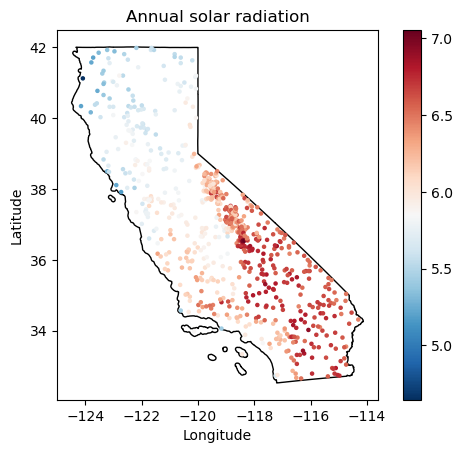

In [23]:
# Load the California shapefile
ca_shapfile_path = data_path+ 'ca_state_boundary/CA_State_TIGER2016.shp'
ca_shape         = gpd.read_file(ca_shapfile_path)
ca_shape         = ca_shape.to_crs("EPSG:4326")
print(ca_shape.crs)


# Plot the county boundaries
fig, ax = plt.subplots()
ca_shape.plot(ax=ax, color='white', edgecolor='black')

# Plot solar_rad data on top of the county boundaries
geo_df_rad.plot(ax=ax, column='solrad_annual', legend=True, markersize=5, cmap='RdBu_r',  missing_kwds={
        "color": "white",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    })


# geo_df_rad.plot(ax=ax, column='solrad_annual', legend=True, markersize=50, cmap='OrRd', alpha=0.5)

# Add titles and labels as needed
plt.title("Annual solar radiation")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Display the plot
plt.show()

## Add data to big dataframe

In [24]:
# Ensure both GeoDataFrames have the same CRS
# Convert ca_features to a GeoDataFrame
gdf_ca_features = gpd.GeoDataFrame(
    ca_grid_sampled, 
    geometry=gpd.points_from_xy(ca_grid_sampled.lon, ca_grid_sampled.lat),
    crs="EPSG:4326"
)

# Ensure ca_rad is a GeoDataFrame with the same CRS
gdf_ca_rad = gpd.GeoDataFrame(
    ca_rad,
    geometry=gpd.points_from_xy(ca_rad.lon, ca_rad.lat),
    crs="EPSG:4326"
)

# Reproject to a suitable projected CRS for accurate distance calculations
gdf_ca_features = gdf_ca_features.to_crs("EPSG:3310")
gdf_ca_rad      = gdf_ca_rad.to_crs("EPSG:3310")


In [25]:
# Perform the spatial join to find the nearest neighbors and get their 'elevation'
ca_features_with_solar_data = gpd.sjoin_nearest(gdf_ca_features, gdf_ca_rad[['geometry', 'solrad_annual','ac_monthly', 'poa_monthly', 'solrad_monthly','dc_monthly','ac_annual']],\
                                                how='left', distance_col='distance')

# If you don't need the distance information, drop the 'distance' column
ca_features_with_solar_data.drop(columns=['index_right', 'distance',], inplace=True)

# Optionally, project back to geographic CRS if needed for other purposes
ca_features_with_solar_data = ca_features_with_solar_data.to_crs("EPSG:4326")

ca_features_with_solar_data

,lat,lon,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,...,slope,land_cover,elevation,geometry,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual
974,41.121933,-124.083541,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,1.0,241.0,POINT (-124.08354 41.12193),4.647099,"[74220.87028531785, 81853.14136114981, 113785....","[89.71184293662846, 99.27773039711408, 142.244...","[2.893930417310596, 3.54563322846836, 4.588518...","[78072.6330660135, 86028.3788149819, 119490.90...",1.351093e+06
40830,34.571305,-120.610359,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,11.0,1.0,244.0,POINT (-120.61036 34.57130),5.449958,"[126910.2673240865, 120953.4951399055, 141626....","[157.4086237937431, 149.0061670892798, 176.243...","[5.07769754173365, 5.321648824617137, 5.685276...","[132842.0433185665, 126964.0270624705, 148524....",1.584719e+06
22134,37.426206,-121.839995,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,1.0,359.0,POINT (-121.83999 37.42621),5.776466,"[93296.39819471513, 94001.73832147277, 148309....","[115.084787852927, 118.3805626840665, 188.1425...","[3.712412511384743, 4.227877238716659, 6.06911...","[97913.03195989196, 98663.10917491073, 155325....",1.631746e+06
82155,33.750032,-117.072459,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,1.0,607.0,POINT (-117.07246 33.75003),6.246080,"[135309.814274307, 123283.186730356, 151155.07...","[170.4540593143596, 156.1909634208012, 197.380...","[5.498518042398696, 5.578248693600041, 6.36712...","[141635.9382116481, 129010.6773886973, 158297....",1.729305e+06
33447,35.705444,-121.063383,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,1.0,506.0,POINT (-121.06338 35.70544),6.172914,"[118738.5864463819, 113457.5578228151, 148653....","[145.3158467865841, 140.9581036133796, 186.941...","[4.687607960857552, 5.034217986192131, 6.03037...","[124417.4689334649, 118908.0059730483, 155818....",1.773539e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3250,39.635821,-123.695234,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,33.0,0.0,241.0,POINT (-123.69523 39.63582),5.609579,"[86209.5050711822, 105554.8883928093, 125741.9...","[107.4079742397352, 132.2522023380131, 162.492...","[3.464773362572104, 4.723292940643324, 5.24168...","[90518.77688892011, 110641.2402901412, 131808....",1.533305e+06
31727,41.063271,-121.192818,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,0.0,1447.0,POINT (-121.19282 41.06327),5.708215,"[96815.43785744013, 101864.4727257321, 136029....","[116.251049306013, 123.9671894301934, 169.5476...","[3.750033848581066, 4.427399622506907, 5.46927...","[101725.3305186939, 107422.7624339342, 143406....",1.616358e+06
42195,38.579898,-120.545641,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,26.0,0.0,1021.0,POINT (-120.54564 38.57990),5.806163,"[90168.10720004485, 109950.798920892, 125291.5...","[113.5886669641835, 138.7754247857646, 162.282...","[3.664150547231725, 4.956265170920164, 5.23491...","[94661.41551299806, 115184.2732353842, 131364....",1.594917e+06
30699,40.183336,-121.257536,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,0.0,1424.0,POINT (-121.25754 40.18334),5.754304,"[93021.8223493916, 88479.23270873418, 134776.6...","[116.205481640678, 113.4133647982922, 176.3380...","[3.748563923892839, 4.050477314224721, 5.68832...","[97596.1932713557, 92924.12236962149, 141261.3...",1.549428e+06


### Finally, save this data as a CSV file

In [26]:
ca_features_with_solar_data.drop(columns='geometry').to_csv(data_path2+'ca_data_version_4.csv', index=False)

In [27]:
ca_features_with_solar_data_check = pd.read_csv(data_path2+'ca_data_version_4.csv')
ca_features_with_solar_data_check 

,lat,lon,Solar_farm_present,State,panel.area,power,panels,landscape.area,water,urban,Address,slope,land_cover,elevation,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual
0,41.121933,-124.083541,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,1.0,241.0,4.647099,"[74220.87028531785, 81853.14136114981, 113785....","[89.71184293662846, 99.27773039711408, 142.244...","[2.893930417310596, 3.54563322846836, 4.588518...","[78072.6330660135, 86028.3788149819, 119490.90...",1.351093e+06
1,34.571305,-120.610359,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1.0,244.0,5.449958,"[126910.2673240865, 120953.4951399055, 141626....","[157.4086237937431, 149.0061670892798, 176.243...","[5.07769754173365, 5.321648824617137, 5.685276...","[132842.0433185665, 126964.0270624705, 148524....",1.584719e+06
2,37.426206,-121.839995,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,1.0,359.0,5.776466,"[93296.39819471513, 94001.73832147277, 148309....","[115.084787852927, 118.3805626840665, 188.1425...","[3.712412511384743, 4.227877238716659, 6.06911...","[97913.03195989196, 98663.10917491073, 155325....",1.631746e+06
3,33.750032,-117.072459,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,1.0,607.0,6.246080,"[135309.814274307, 123283.186730356, 151155.07...","[170.4540593143596, 156.1909634208012, 197.380...","[5.498518042398696, 5.578248693600041, 6.36712...","[141635.9382116481, 129010.6773886973, 158297....",1.729305e+06
4,35.705444,-121.063383,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,1.0,506.0,6.172914,"[118738.5864463819, 113457.5578228151, 148653....","[145.3158467865841, 140.9581036133796, 186.941...","[4.687607960857552, 5.034217986192131, 6.03037...","[124417.4689334649, 118908.0059730483, 155818....",1.773539e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,39.635821,-123.695234,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,0.0,241.0,5.609579,"[86209.5050711822, 105554.8883928093, 125741.9...","[107.4079742397352, 132.2522023380131, 162.492...","[3.464773362572104, 4.723292940643324, 5.24168...","[90518.77688892011, 110641.2402901412, 131808....",1.533305e+06
996,41.063271,-121.192818,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,1447.0,5.708215,"[96815.43785744013, 101864.4727257321, 136029....","[116.251049306013, 123.9671894301934, 169.5476...","[3.750033848581066, 4.427399622506907, 5.46927...","[101725.3305186939, 107422.7624339342, 143406....",1.616358e+06
997,38.579898,-120.545641,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,0.0,1021.0,5.806163,"[90168.10720004485, 109950.798920892, 125291.5...","[113.5886669641835, 138.7754247857646, 162.282...","[3.664150547231725, 4.956265170920164, 5.23491...","[94661.41551299806, 115184.2732353842, 131364....",1.594917e+06
998,40.183336,-121.257536,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,0.0,1424.0,5.754304,"[93021.8223493916, 88479.23270873418, 134776.6...","[116.205481640678, 113.4133647982922, 176.3380...","[3.748563923892839, 4.050477314224721, 5.68832...","[97596.1932713557, 92924.12236962149, 141261.3...",1.549428e+06
